# Lezione 15 – XGBoost e LightGBM: Gradient Boosting in Produzione

---

## Mappa della Lezione

| # | Sezione | Domanda-guida | Minuti |
|---|---------|---------------|--------|
| 1 | Obiettivi e prerequisiti | Perché XGBoost domina le competizioni? | 3 |
| 2 | Teoria profonda e rationale | Come funziona il boosting sequenziale? | 25 |
| 3 | Schema mentale / mappa decisionale | XGBoost vs LightGBM vs CatBoost? | 5 |
| 4 | Sezione dimostrativa | Come uso early stopping? | 25 |
| 5 | Esercizi e consolidamento | Riesco a fare tuning efficace? | 15 |
| 6 | Conclusione operativa | Cosa porto a casa? | 3 |
| 7 | Checklist di fine lezione | Sono pronto per proseguire? | 2 |
| 8 | Changelog didattico | Come si è evoluto il materiale? | 1 |

---

## Obiettivi di Apprendimento

| ID | Obiettivo | Verifica | Livello |
|----|-----------|----------|---------|
| O1 | Capire la differenza tra Bagging e Boosting | Spiegare perché boosting è sequenziale | 🟢 Fondamentale |
| O2 | Comprendere come funziona Gradient Boosting | Spiegare il ruolo dei residui | 🟢 Fondamentale |
| O3 | Usare XGBoost con early stopping | Implementare fit con eval_set | 🟡 Intermedio |
| O4 | Usare LightGBM con categoriche native | Passare categorical_feature | 🟡 Intermedio |
| O5 | Ottimizzare iperparametri con GridSearchCV | Fare tuning sequenziale efficiente | 🔴 Avanzato |
| O6 | Scegliere l'algoritmo giusto per il contesto | Decidere tra RF, XGB, LGBM | 🔴 Avanzato |

---

## Prerequisiti

| Requisito | Lezione | Concetto chiave | Auto-verifica |
|-----------|---------|-----------------|---------------|
| Decision Trees | Lesson 14 | Come funziona uno split | Sai cosa fa max_depth? |
| Random Forest | Lesson 14 | Bagging e feature sampling | Sai cos'è oob_score? |
| Gradient Boosting base | Lesson 10 | Boosting sequenziale | Sai la formula $F_m$? |
| Cross-Validation | Lesson 11 | K-Fold, scoring | Sai fare cross_val_score? |
| GridSearchCV | Lesson 13 | Hyperparameter tuning | Sai cercare parametri? |

> ⚠️ **Nota**: XGBoost/LightGBM sono i modelli più usati nelle competizioni Kaggle e in produzione per dati tabulari.

---

## Perché Queste Librerie

### Contesto Storico e Industriale

| Anno | Milestone | Impatto |
|------|-----------|---------|
| 2014 | XGBoost di Tianqi Chen | Dominio nelle competizioni Kaggle |
| 2017 | LightGBM di Microsoft | 10-20x più veloce su grandi dataset |
| 2017 | CatBoost di Yandex | Gestione nativa categoriche |
| 2020+ | Standard in produzione | Google, Amazon, Netflix, banche |

### Vantaggi Rispetto a sklearn.GradientBoostingClassifier

| Aspetto | sklearn GB | XGBoost | LightGBM |
|---------|------------|---------|----------|
| Velocità | ⚠️ Lento | ✅ Veloce | ✅✅ Molto veloce |
| Parallelismo | ❌ No | ✅ Sì | ✅ Sì |
| Early Stopping | ⚠️ Manuale | ✅ Integrato | ✅ Integrato |
| Regularization | ❌ No | ✅ L1/L2 | ✅ L1/L2 |
| Missing Values | ❌ Errore | ✅ Gestiti | ✅ Gestiti |
| Categoriche Native | ❌ No | ❌ No | ✅ Sì |

---

## La Formula del Gradient Boosting

$$F_M(x) = F_0(x) + \sum_{m=1}^{M} \eta \cdot h_m(x)$$

| Simbolo | Significato | Valore tipico |
|---------|-------------|---------------|
| $F_0(x)$ | Predizione iniziale (media/log-odds) | - |
| $\eta$ | Learning rate (shrinkage) | 0.01 - 0.2 |
| $h_m(x)$ | Albero che predice i residui | max_depth 3-6 |
| $M$ | Numero totale di alberi | 100 - 1000+ |

### La Regola d'Oro

```
learning_rate ↓  +  n_estimators ↑  =  Più stabile, più lento
learning_rate ↑  +  n_estimators ↓  =  Più veloce, meno stabile

Prodotto: η × M ≈ 10-30 (regola empirica)
```

---

## Bagging vs Boosting

| Aspetto | Bagging (RF) | Boosting (XGB/LGBM) |
|---------|--------------|---------------------|
| **Strategia** | Parallela | Sequenziale |
| **Obiettivo** | Ridurre varianza | Ridurre bias + varianza |
| **Alberi** | Profondi, indipendenti | Poco profondi, dipendenti |
| **max_depth tipico** | 10-30 o None | 3-10 |
| **Overfitting** | Basso (intrinseco) | Alto senza tuning |
| **Tuning richiesto** | Minimo | Significativo |

---

## Librerie Utilizzate

```python
# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor

# Standard
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
```

---

## Navigazione Veloce

- [Teoria Gradient Boosting](#2-teoria-concettuale-profonda)
- [Schema XGB vs LGBM](#3-schema-mentale--mappa-decisionale)
- [Esercizi pratici](#4-sezione-dimostrativa)
- [Conclusione](#6-conclusione-operativa)

---

# 2) Teoria concettuale profonda

### 1.1 Bagging vs Boosting: Due Filosofie di Ensemble

| Aspetto | Bagging (Random Forest) | Boosting (XGBoost, LightGBM) |
|---------|-------------------------|------------------------------|
| Costruzione | Parallela | Sequenziale |
| Focus | Ridurre varianza | Ridurre bias + varianza |
| Peso alberi | Uguale | Pesato per performance |
| Rischio overfitting | Basso | Medio-Alto |
| Velocita | Parallelizzabile | Sequenziale |

#### Bagging
> "Allenare tanti modelli in parallelo su campioni diversi e fare la media"

```
Dataset --> Sample 1 --> Tree 1 --+
        --> Sample 2 --> Tree 2 --+--> MEDIA/VOTO --> Predizione
        --> Sample N --> Tree N --+
```

#### Boosting
> "Allenare tanti modelli in sequenza, ognuno corregge gli errori del precedente"

```
Tree 1 --> Errori --> Tree 2 --> Errori --> Tree 3 --> ... --> SOMMA PESATA --> Predizione
```

---

### 1.2 Gradient Boosting: L'Idea Matematica

1. **Inizializza** con una predizione semplice (es. media)
2. **Calcola i residui** (errori) tra predizione e valori reali
3. **Addestra un albero** per predire questi residui
4. **Aggiorna le predizioni** aggiungendo le predizioni dell'albero (con learning rate)
5. **Ripeti** dal passo 2

#### Formula

$$F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)$$

Dove:
- $F_m(x)$ = predizione dopo m alberi
- $\eta$ = learning rate (0 < eta <= 1)
- $h_m(x)$ = nuovo albero che predice i residui

#### Learning Rate

| Learning Rate | Effetto |
|---------------|---------|
| Alto (0.3-1.0) | Apprendimento veloce, rischio overfitting |
| Basso (0.01-0.1) | Apprendimento lento, piu robusto |

**Regola**: Basso learning rate + piu alberi = migliore generalizzazione

---

### 1.3 XGBoost (eXtreme Gradient Boosting)

Implementazione ottimizzata del Gradient Boosting con:

| Feature | Descrizione |
|---------|-------------|
| Regularizzazione | L1 e L2 built-in (previene overfitting) |
| Parallelizzazione | Costruzione alberi parallelizzata |
| Gestione missing | Gestisce valori mancanti nativamente |
| Tree pruning | Potatura piu efficiente |
| Early stopping | Ferma quando validation smette di migliorare |

---

### 1.4 LightGBM (Light Gradient Boosting Machine)

Sviluppato da Microsoft, ancora piu veloce di XGBoost:

| Aspetto | XGBoost | LightGBM |
|---------|---------|----------|
| Crescita albero | Level-wise (per livello) | Leaf-wise (per foglia) |
| Velocita | Veloce | Ancora piu veloce |
| Memoria | Standard | Ottimizzata |
| Categoriche | Richiede encoding | Supporto nativo |

#### Level-wise vs Leaf-wise

```
LEVEL-WISE (XGBoost)           LEAF-WISE (LightGBM)
Cresce un livello alla volta   Espande la foglia con max gain

      o                              o
     / \                            / \
    o   o     <-- livello 1        o   o
   / \ / \                        / \
  o o o o     <-- livello 2      o   o
                                    / \
                                   o   o  <-- espansione selettiva
```

---

### 1.5 Early Stopping

Ferma il training quando lo score di validazione smette di migliorare:

```python
## XGBoost
xgb_clf.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=30)

## LightGBM
lgb_clf.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(30)])
```

**Vantaggi**:
- Previene overfitting
- Risparmia tempo di training
- Identifica automaticamente il numero ottimale di alberi

---

# 3) Schema mentale / mappa decisionale

### Flusso Decisionale: Quale Modello Ensemble Scegliere?

```
                    QUALE MODELLO ENSEMBLE?
                           |
         +-----------------+-----------------+
         |                 |                 |
    BASELINE          PERFORMANCE        BIG DATA
    RICHIESTA          MASSIMA           VELOCITA
         |                 |                 |
         v                 v                 v
   Random Forest       XGBoost          LightGBM
   (semplice)       (competizioni)     (produzione)
```

### Schema Gradient Boosting

```
+--------------------------------------------------+
|              GRADIENT BOOSTING                    |
|                                                   |
|   Predizione iniziale (media)                    |
|         |                                         |
|         v                                         |
|   +--------+                                      |
|   | Tree 1 | --> predice residui                 |
|   +--------+                                      |
|         |                                         |
|         v  (aggiorna predizione: F += eta * h1)  |
|   +--------+                                      |
|   | Tree 2 | --> predice nuovi residui           |
|   +--------+                                      |
|         |                                         |
|         v  (aggiorna: F += eta * h2)             |
|        ...                                        |
|         |                                         |
|         v                                         |
|   PREDIZIONE FINALE = somma pesata               |
+--------------------------------------------------+
```

### Confronto Modelli

```
                    ACCURACY
                       ^
                       |
    XGBoost/LightGBM   | *****
    Random Forest      | ****
    Decision Tree      | **
                       |
                       +-----------------------> VELOCITA
                           DT > RF > XGB > LGB (training)
                           LGB > XGB > RF > DT (prediction)
```

### Iperparametri Critici

```
n_estimators: 100-500
  |
  +-> Piu alberi = piu stabile (ma piu lento)

learning_rate: 0.01-0.3
  |
  +-> Basso = robusto ma richiede piu alberi

max_depth: 3-10 (boosting) vs 10-30 (bagging)
  |
  +-> Boosting usa alberi piu shallow!

early_stopping_rounds: 10-50
  |
  +-> Ferma quando validation peggiora
```

---

# 4) Sezione dimostrativa

In questa sezione vedremo 5 esercizi pratici:

1. **Esercizio 1**: Gradient Boosting - Visualizzazione del Processo
2. **Esercizio 2**: Confronto RF vs XGBoost vs LightGBM  
3. **Esercizio 3**: XGBoost con Early Stopping
4. **Esercizio 4**: LightGBM con Categoriche Native
5. **Esercizio 5**: Tuning XGBoost con GridSearchCV

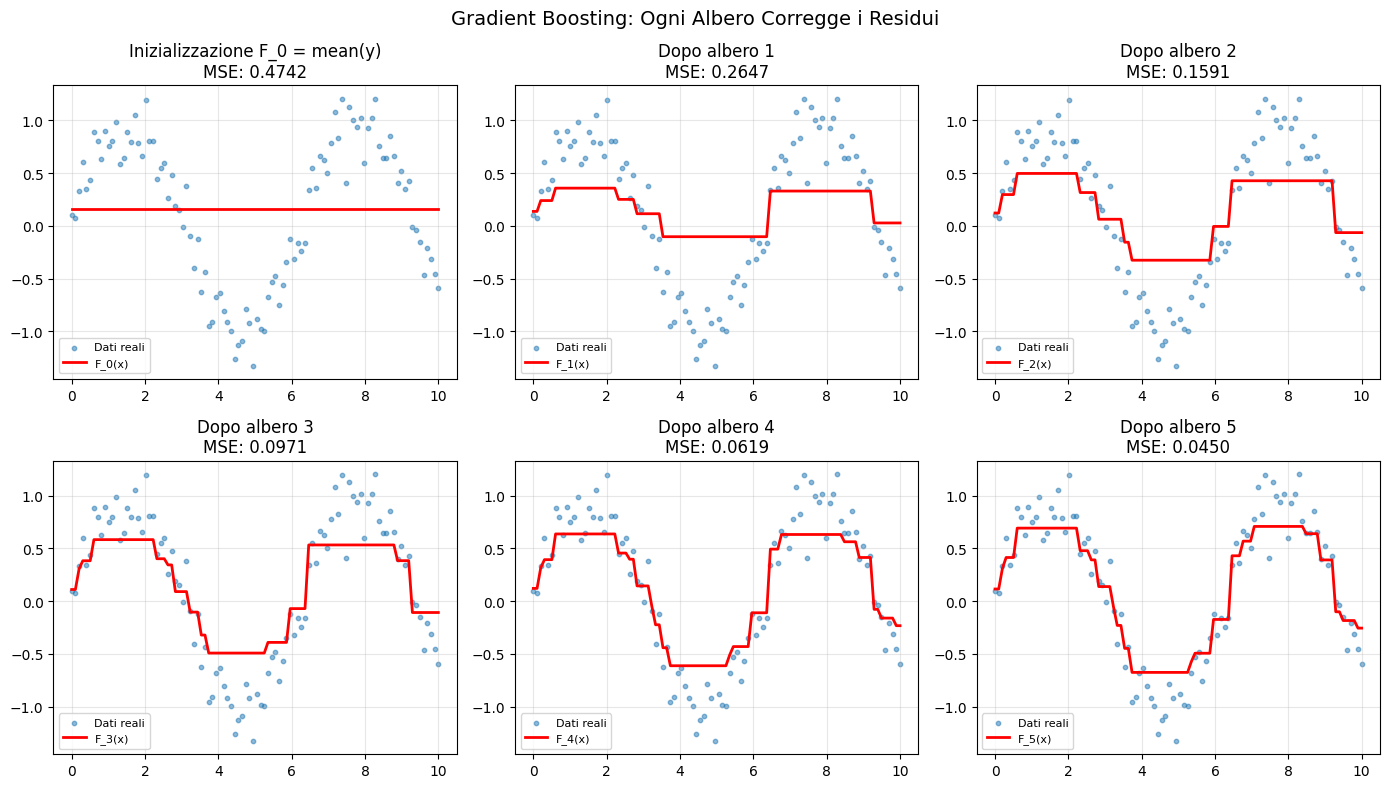

MSE iniziale (F0): 0.4742
MSE finale (F5): 0.0450
Riduzione MSE: 90.5%

[OK] Gradient Boosting riduce progressivamente l'errore!


In [1]:
# === ESERCIZIO 1: GRADIENT BOOSTING - VISUALIZZAZIONE DEL PROCESSO ===
# Perche: capiamo come ogni albero corregge gli errori del precedente

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# Dati sintetici semplici per visualizzazione
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(X.ravel()) + np.random.normal(0, 0.2, 100)

# Costruiamo Gradient Boosting passo passo
learning_rate = 0.3
n_estimators = 5

# Inizializzazione: predizione costante (media di y)
F0 = np.mean(y)
predictions = [np.full_like(y, F0)]
residuals_history = []
trees = []

current_prediction = np.full_like(y, F0)
for i in range(n_estimators):
    # 1. Calcola residui
    residuals = y - current_prediction
    residuals_history.append(residuals.copy())
    
    # 2. Addestra albero sui residui
    tree = DecisionTreeRegressor(max_depth=3)
    tree.fit(X, residuals)
    trees.append(tree)
    
    # 3. Aggiorna predizione
    current_prediction = current_prediction + learning_rate * tree.predict(X)
    predictions.append(current_prediction.copy())

# Visualizzazione
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i in range(min(6, n_estimators + 1)):
    ax = axes[i]
    ax.scatter(X, y, alpha=0.5, s=10, label='Dati reali')
    ax.plot(X, predictions[i], 'r-', linewidth=2, label=f'F_{i}(x)')
    if i > 0:
        ax.set_title(f'Dopo albero {i}\nMSE: {np.mean((y - predictions[i])**2):.4f}')
    else:
        ax.set_title(f'Inizializzazione F_0 = mean(y)\nMSE: {np.mean((y - predictions[i])**2):.4f}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Gradient Boosting: Ogni Albero Corregge i Residui', fontsize=14)
plt.tight_layout()
plt.show()

# Verifica: MSE diminuisce
mse_iniziale = np.mean((y - predictions[0])**2)
mse_finale = np.mean((y - predictions[-1])**2)
print(f"MSE iniziale (F0): {mse_iniziale:.4f}")
print(f"MSE finale (F{n_estimators}): {mse_finale:.4f}")
print(f"Riduzione MSE: {((mse_iniziale - mse_finale) / mse_iniziale * 100):.1f}%")

# MICRO-CHECKPOINT
assert mse_finale < mse_iniziale, "MSE deve diminuire con boosting"
assert len(trees) == n_estimators, f"Devono esserci {n_estimators} alberi"
print("\n[OK] Gradient Boosting riduce progressivamente l'errore!")

Random Forest       : Accuracy=0.9370, Train=0.153s, Pred=0.0292s
XGBoost             : Accuracy=0.9640, Train=0.074s, Pred=0.0014s
LightGBM            : Accuracy=0.9590, Train=1.424s, Pred=0.0025s


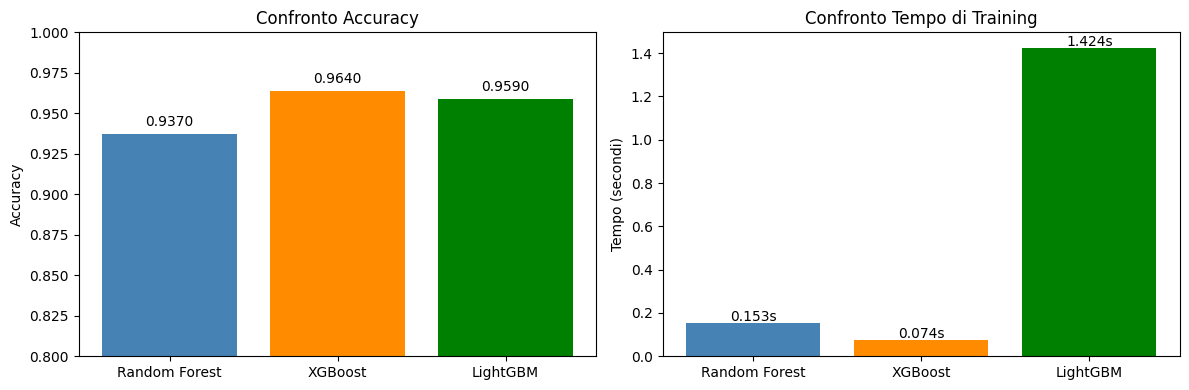


Migliore accuracy: XGBoost (0.9640)
Piu veloce: XGBoost (0.074s)

[OK] Confronto completato!


In [2]:
# === ESERCIZIO 2: CONFRONTO RF VS XGBOOST VS LIGHTGBM ===
# Perche: confrontiamo accuracy e velocita dei tre modelli principali

import time
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

# Prova a importare XGBoost e LightGBM
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False
    print("XGBoost non installato - uso GradientBoosting sklearn come fallback")

try:
    from lightgbm import LGBMClassifier
    lgbm_available = True
except ImportError:
    lgbm_available = False
    print("LightGBM non installato - uso GradientBoosting sklearn come fallback")

# Dataset sintetico
X, y = make_classification(n_samples=5000, n_features=20, n_informative=15,
                           n_redundant=3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelli
modelli = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
}

if xgb_available:
    modelli['XGBoost'] = XGBClassifier(n_estimators=100, random_state=42, 
                                        use_label_encoder=False, eval_metric='logloss',
                                        verbosity=0)
else:
    modelli['GradientBoosting'] = GradientBoostingClassifier(n_estimators=100, random_state=42)

if lgbm_available:
    modelli['LightGBM'] = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)

risultati = {}
for nome, modello in modelli.items():
    start = time.time()
    modello.fit(X_train, y_train)
    tempo_train = time.time() - start
    
    start = time.time()
    accuracy = modello.score(X_test, y_test)
    tempo_pred = time.time() - start
    
    risultati[nome] = {
        'accuracy': accuracy,
        'tempo_train': tempo_train,
        'tempo_pred': tempo_pred
    }
    print(f"{nome:20s}: Accuracy={accuracy:.4f}, Train={tempo_train:.3f}s, Pred={tempo_pred:.4f}s")

# Visualizzazione
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

nomi = list(risultati.keys())
accuracies = [risultati[n]['accuracy'] for n in nomi]
tempi = [risultati[n]['tempo_train'] for n in nomi]

colors = ['steelblue', 'darkorange', 'green'][:len(nomi)]

axes[0].bar(nomi, accuracies, color=colors)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Confronto Accuracy')
axes[0].set_ylim(0.8, 1.0)
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.005, f'{v:.4f}', ha='center')

axes[1].bar(nomi, tempi, color=colors)
axes[1].set_ylabel('Tempo (secondi)')
axes[1].set_title('Confronto Tempo di Training')
for i, v in enumerate(tempi):
    axes[1].text(i, v + 0.01, f'{v:.3f}s', ha='center')

plt.tight_layout()
plt.show()

# Analisi
migliore = max(risultati.keys(), key=lambda x: risultati[x]['accuracy'])
piu_veloce = min(risultati.keys(), key=lambda x: risultati[x]['tempo_train'])
print(f"\nMigliore accuracy: {migliore} ({risultati[migliore]['accuracy']:.4f})")
print(f"Piu veloce: {piu_veloce} ({risultati[piu_veloce]['tempo_train']:.3f}s)")

# MICRO-CHECKPOINT
assert all(r['accuracy'] > 0.85 for r in risultati.values()), "Tutti i modelli devono avere accuracy > 85%"
print("\n[OK] Confronto completato!")

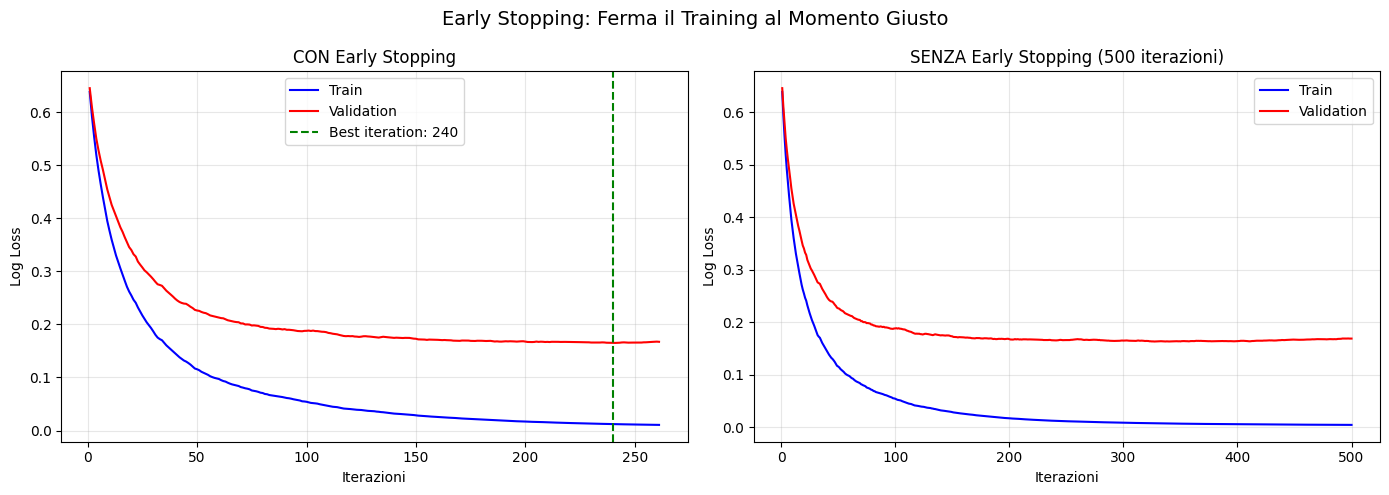


=== RISULTATI ===
Con Early Stopping: 240 iterazioni, Accuracy=0.9422
Senza Early Stopping: 500 iterazioni, Accuracy=0.9511
Risparmio: 260 iterazioni (52.0%)

[OK] Early stopping funziona correttamente!


In [3]:
# === ESERCIZIO 3: XGBOOST CON EARLY STOPPING ===
# Perche: early stopping previene overfitting e risparmia tempo

import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Prova a importare XGBoost
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False

if xgb_available:
    # Dataset
    X, y = make_classification(n_samples=3000, n_features=20, n_informative=15,
                               random_state=42)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # Modello CON early stopping
    model_early = XGBClassifier(
        n_estimators=500,  # massimo
        learning_rate=0.1,
        max_depth=5,
        early_stopping_rounds=20,  # ferma se non migliora per 20 round
        random_state=42,
        eval_metric='logloss',
        verbosity=0
    )
    
    model_early.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_val, y_val)],
                    verbose=False)
    
    # Estraiamo le curve di learning
    results = model_early.evals_result()
    train_logloss = results['validation_0']['logloss']
    val_logloss = results['validation_1']['logloss']
    
    # Modello SENZA early stopping per confronto
    model_no_early = XGBClassifier(
        n_estimators=500,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        eval_metric='logloss',
        verbosity=0
    )
    model_no_early.fit(X_train, y_train, 
                       eval_set=[(X_train, y_train), (X_val, y_val)],
                       verbose=False)
    
    results_no = model_no_early.evals_result()
    val_logloss_no = results_no['validation_1']['logloss']
    
    # Visualizzazione
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Curva con early stopping
    epochs = range(1, len(train_logloss) + 1)
    axes[0].plot(epochs, train_logloss, 'b-', label='Train')
    axes[0].plot(epochs, val_logloss, 'r-', label='Validation')
    axes[0].axvline(x=model_early.best_iteration, color='g', linestyle='--', 
                    label=f'Best iteration: {model_early.best_iteration}')
    axes[0].set_xlabel('Iterazioni')
    axes[0].set_ylabel('Log Loss')
    axes[0].set_title('CON Early Stopping')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Curva senza early stopping
    epochs_no = range(1, len(val_logloss_no) + 1)
    axes[1].plot(epochs_no, results_no['validation_0']['logloss'], 'b-', label='Train')
    axes[1].plot(epochs_no, val_logloss_no, 'r-', label='Validation')
    axes[1].set_xlabel('Iterazioni')
    axes[1].set_ylabel('Log Loss')
    axes[1].set_title('SENZA Early Stopping (500 iterazioni)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle('Early Stopping: Ferma il Training al Momento Giusto', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Confronto performance
    acc_early = model_early.score(X_test, y_test)
    acc_no = model_no_early.score(X_test, y_test)
    
    print(f"\n=== RISULTATI ===")
    print(f"Con Early Stopping: {model_early.best_iteration} iterazioni, Accuracy={acc_early:.4f}")
    print(f"Senza Early Stopping: 500 iterazioni, Accuracy={acc_no:.4f}")
    print(f"Risparmio: {500 - model_early.best_iteration} iterazioni ({(500 - model_early.best_iteration)/500*100:.1f}%)")
    
    # MICRO-CHECKPOINT
    assert model_early.best_iteration < 500, "Early stopping deve fermarsi prima di 500"
    assert acc_early >= acc_no - 0.02, "Early stopping non deve peggiorare significativamente"
    print("\n[OK] Early stopping funziona correttamente!")
else:
    print("XGBoost non disponibile - dimostriamo con sklearn")
    from sklearn.ensemble import GradientBoostingClassifier
    
    X, y = make_classification(n_samples=2000, n_features=20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = GradientBoostingClassifier(n_estimators=100, validation_fraction=0.1,
                                        n_iter_no_change=10, random_state=42)
    model.fit(X_train, y_train)
    
    print(f"Iterazioni usate: {model.n_estimators_} su 100")
    print(f"Accuracy: {model.score(X_test, y_test):.4f}")
    print("\n[OK] Dimostrato con sklearn GradientBoosting!")

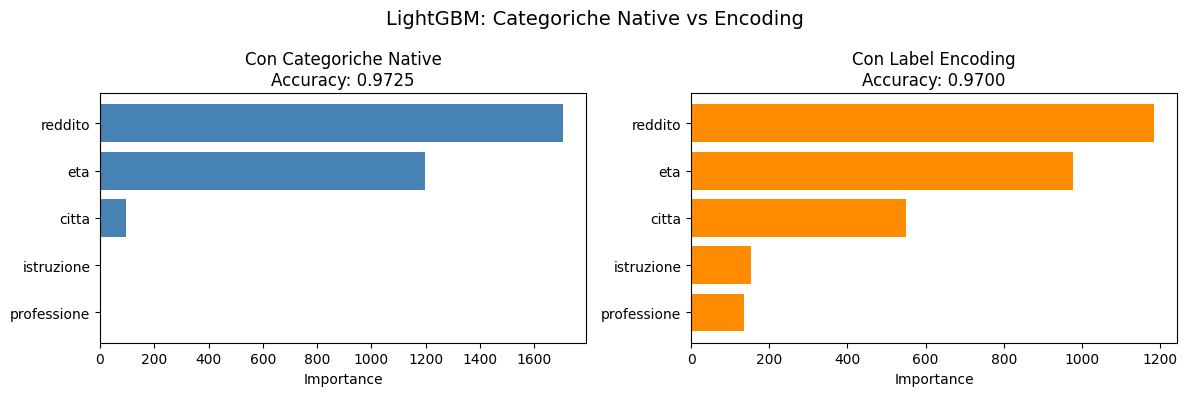


=== CONFRONTO ===
Categoriche Native: Accuracy = 0.9725
Label Encoding:     Accuracy = 0.9700
Differenza: +0.25%

[OK] LightGBM gestisce categoriche native!


In [4]:
# === ESERCIZIO 4: LIGHTGBM CON CATEGORICHE NATIVE ===
# Perche: LightGBM gestisce categoriche senza one-hot encoding

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Prova a importare LightGBM
try:
    from lightgbm import LGBMClassifier
    lgbm_available = True
except ImportError:
    lgbm_available = False

if lgbm_available:
    # Creiamo dataset con categoriche
    np.random.seed(42)
    n_samples = 2000
    
    data = pd.DataFrame({
        'eta': np.random.randint(18, 70, n_samples),
        'reddito': np.random.exponential(30000, n_samples),
        'citta': np.random.choice(['Milano', 'Roma', 'Napoli', 'Torino', 'Firenze'], n_samples),
        'professione': np.random.choice(['Impiegato', 'Manager', 'Operaio', 'Libero Prof', 'Studente'], n_samples),
        'istruzione': np.random.choice(['Diploma', 'Laurea', 'Master', 'Dottorato'], n_samples)
    })
    
    # Target: probabilita acquisto basata su feature
    prob = (data['eta'] / 100 + 
            np.log1p(data['reddito']) / 20 +
            data['citta'].map({'Milano': 0.2, 'Roma': 0.15, 'Napoli': 0.1, 
                               'Torino': 0.1, 'Firenze': 0.15}).values)
    data['acquisto'] = (prob > np.median(prob)).astype(int)
    
    # Convertiamo categoriche
    cat_columns = ['citta', 'professione', 'istruzione']
    for col in cat_columns:
        data[col] = data[col].astype('category')
    
    X = data.drop('acquisto', axis=1)
    y = data['acquisto']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Modello CON categoriche native
    model_cat = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
    model_cat.fit(X_train, y_train, categorical_feature=cat_columns)
    acc_cat = model_cat.score(X_test, y_test)
    
    # Modello con Label Encoding (tradizionale)
    X_encoded = data.drop('acquisto', axis=1).copy()
    for col in cat_columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col])
    
    X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(
        X_encoded, y, test_size=0.2, random_state=42)
    
    model_enc = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
    model_enc.fit(X_train_enc, y_train_enc)
    acc_enc = model_enc.score(X_test_enc, y_test_enc)
    
    # Feature importance
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Importance con categoriche native
    importance_cat = pd.DataFrame({
        'feature': X.columns,
        'importance': model_cat.feature_importances_
    }).sort_values('importance', ascending=True)
    
    axes[0].barh(importance_cat['feature'], importance_cat['importance'], color='steelblue')
    axes[0].set_title(f'Con Categoriche Native\nAccuracy: {acc_cat:.4f}')
    axes[0].set_xlabel('Importance')
    
    # Importance con encoding
    importance_enc = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': model_enc.feature_importances_
    }).sort_values('importance', ascending=True)
    
    axes[1].barh(importance_enc['feature'], importance_enc['importance'], color='darkorange')
    axes[1].set_title(f'Con Label Encoding\nAccuracy: {acc_enc:.4f}')
    axes[1].set_xlabel('Importance')
    
    plt.suptitle('LightGBM: Categoriche Native vs Encoding', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== CONFRONTO ===")
    print(f"Categoriche Native: Accuracy = {acc_cat:.4f}")
    print(f"Label Encoding:     Accuracy = {acc_enc:.4f}")
    print(f"Differenza: {(acc_cat - acc_enc)*100:+.2f}%")
    
    # MICRO-CHECKPOINT
    assert acc_cat > 0.6, "Accuracy deve essere ragionevole"
    print("\n[OK] LightGBM gestisce categoriche native!")
else:
    print("LightGBM non disponibile")
    print("\nPer installare: pip install lightgbm")
    print("\nCategorie native sono una feature esclusiva di LightGBM e CatBoost.")
    print("Vantaggi:")
    print("- Non serve one-hot encoding")
    print("- Gestisce automaticamente l'ordinamento ottimale")
    print("- Piu efficiente in memoria")
    print("\n[OK] Concetto spiegato!")

Score modello base (default): 0.9225

Combinazioni totali: 54 = 54
Eseguo GridSearchCV...

Migliori parametri: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Miglior CV score: 0.9206

=== CONFRONTO SU TEST SET ===
Modello base:     0.9375
Modello tuned:    0.9325
Miglioramento:    -0.50%

=== TOP 10 CONFIGURAZIONI ===
Rank 1: Score=0.9206 +/- 0.0138
Rank 2: Score=0.9200 +/- 0.0163
Rank 3: Score=0.9200 +/- 0.0141
Rank 4: Score=0.9188 +/- 0.0138
Rank 5: Score=0.9188 +/- 0.0048
Rank 6: Score=0.9175 +/- 0.0155
Rank 7: Score=0.9175 +/- 0.0110
Rank 8: Score=0.9169 +/- 0.0147
Rank 9: Score=0.9169 +/- 0.0098
Rank 10: Score=0.9163 +/- 0.0131


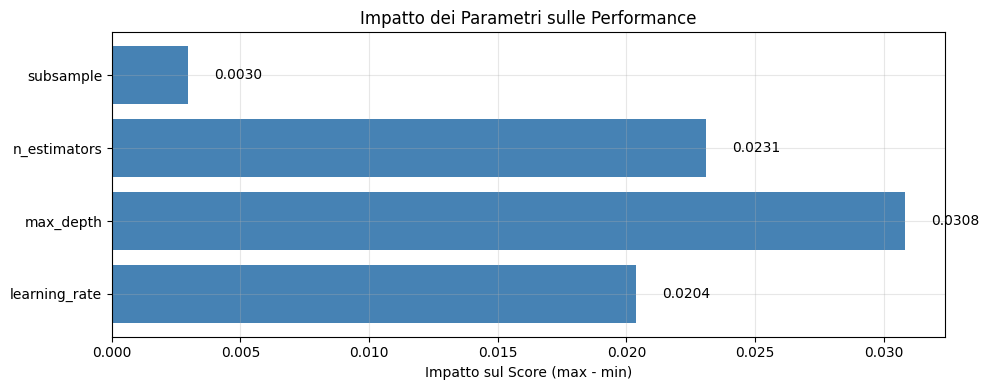


[OK] Tuning XGBoost completato!


In [6]:
# === ESERCIZIO 5: TUNING XGBOOST CON GRIDSEARCHCV ===
# Perche: ottimizzare gli iperparametri per massimizzare le performance

import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Prova a importare XGBoost
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False

if xgb_available:
    # Dataset
    X, y = make_classification(n_samples=2000, n_features=20, n_informative=15,
                               random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Modello base
    base_model = XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0)
    base_score = cross_val_score(base_model, X_train, y_train, cv=5).mean()
    print(f"Score modello base (default): {base_score:.4f}")
    
    # Griglia di iperparametri (ridotta per velocita)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }
    
    print(f"\nCombinazioni totali: {3*3*3*2} = 54")
    print("Eseguo GridSearchCV...")
    
    grid_search = GridSearchCV(
        XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0),
        param_grid,
        cv=3,  # 3-fold per velocita
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"\nMigliori parametri: {grid_search.best_params_}")
    print(f"Miglior CV score: {grid_search.best_score_:.4f}")
    
    # Test finale
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    base_model.fit(X_train, y_train)
    base_test_score = base_model.score(X_test, y_test)
    
    print(f"\n=== CONFRONTO SU TEST SET ===")
    print(f"Modello base:     {base_test_score:.4f}")
    print(f"Modello tuned:    {test_score:.4f}")
    print(f"Miglioramento:    {(test_score - base_test_score)*100:+.2f}%")
    
    # Visualizzazione top risultati
    import pandas as pd
    import matplotlib.pyplot as plt
    
    results_df = pd.DataFrame(grid_search.cv_results_)
    top_10 = results_df.nsmallest(10, 'rank_test_score')[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
    
    print("\n=== TOP 10 CONFIGURAZIONI ===")
    for i, row in top_10.iterrows():
        print(f"Rank {row['rank_test_score']}: Score={row['mean_test_score']:.4f} +/- {row['std_test_score']:.4f}")
    
    # Grafico importanza parametri
    fig, ax = plt.subplots(figsize=(10, 4))
    
    # Analisi impatto parametri
    params_names = ['learning_rate', 'max_depth', 'n_estimators', 'subsample']
    impacts = []
    for param in params_names:
        values = results_df[f'param_{param}'].unique()
        scores_per_value = [results_df[results_df[f'param_{param}'] == v]['mean_test_score'].mean() for v in values]
        impact = max(scores_per_value) - min(scores_per_value)
        impacts.append(impact)
    
    ax.barh(params_names, impacts, color='steelblue')
    ax.set_xlabel('Impatto sul Score (max - min)')
    ax.set_title('Impatto dei Parametri sulle Performance')
    ax.grid(True, alpha=0.3)
    
    for i, v in enumerate(impacts):
        ax.text(v + 0.001, i, f'{v:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # MICRO-CHECKPOINT
    # Nota: GridSearchCV usa CV, quindi il best_score puo differire dal base_score calcolato su split diversi
    assert grid_search.best_score_ > 0.85, "CV score deve essere ragionevole"
    assert test_score > 0.85, "Test accuracy deve essere ragionevole"
    print("\n[OK] Tuning XGBoost completato!")
else:
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.model_selection import GridSearchCV
    
    X, y = make_classification(n_samples=1500, n_features=20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    param_grid = {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]}
    
    grid = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print(f"Migliori parametri: {grid.best_params_}")
    print(f"CV Score: {grid.best_score_:.4f}")
    print(f"Test Score: {grid.score(X_test, y_test):.4f}")
    print("\n[OK] Dimostrato con sklearn!")

---

# 5) Esercizi risolti (step by step)

### XGBClassifier / XGBRegressor (xgboost)
| Metodo/Parametro | Descrizione |
|------------------|-------------|
| `n_estimators` | Numero di alberi (default 100) |
| `learning_rate` | Peso di ogni albero (default 0.3, consigliato 0.01-0.2) |
| `max_depth` | Profondita massima alberi (default 6, per boosting 3-10) |
| `subsample` | Frazione campioni per albero (default 1.0) |
| `colsample_bytree` | Frazione feature per albero |
| `early_stopping_rounds` | Ferma se no improvement per N round |
| `eval_metric` | Metrica per early stopping ('logloss', 'auc', 'rmse') |
| `reg_alpha` | L1 regularization (Lasso) |
| `reg_lambda` | L2 regularization (Ridge) |
| `fit(X, y, eval_set)` | Addestra con validation set |
| `predict(X)` | Predice classi/valori |
| `predict_proba(X)` | Predice probabilita |
| `feature_importances_` | Importanza delle feature |
| `best_iteration` | Iterazione ottimale (con early stopping) |

### LGBMClassifier / LGBMRegressor (lightgbm)
| Metodo/Parametro | Descrizione |
|------------------|-------------|
| `n_estimators` | Numero di alberi |
| `learning_rate` | Peso di ogni albero (default 0.1) |
| `max_depth` | Profondita massima (-1 = no limit) |
| `num_leaves` | Foglie per albero (default 31) - alternativa a max_depth |
| `min_child_samples` | Minimo campioni per foglia |
| `subsample` | Frazione campioni |
| `colsample_bytree` | Frazione feature |
| `categorical_feature` | Lista colonne categoriche native |
| `boosting_type` | 'gbdt', 'dart', 'goss', 'rf' |
| `verbose` | -1 per silenzio |
| `fit(X, y, categorical_feature)` | Addestra con categoriche native |

### GradientBoostingClassifier/Regressor (sklearn)
| Metodo/Parametro | Descrizione |
|------------------|-------------|
| `n_estimators` | Numero di alberi (default 100) |
| `learning_rate` | Peso alberi (default 0.1) |
| `max_depth` | Profondita (default 3 - piu conservativo) |
| `min_samples_split` | Minimo campioni per split |
| `min_samples_leaf` | Minimo campioni per foglia |
| `subsample` | Frazione campioni (<1.0 = Stochastic GB) |
| `validation_fraction` | Frazione per early stopping |
| `n_iter_no_change` | Iterazioni senza miglioramento per stop |
| `loss` | Funzione di loss ('log_loss', 'exponential') |

### Confronto Velocita e Feature
| Aspetto | sklearn GB | XGBoost | LightGBM |
|---------|-----------|---------|----------|
| Velocita | Lenta | Media | Veloce |
| Categoriche native | No | No | Si |
| GPU support | No | Si | Si |
| Sparse data | Base | Ottimo | Ottimo |
| Early stopping | Si | Si | Si |
| Parallelismo | No | Si | Si |

---

### Glossario essenziale (dentro la sezione 2)
Questa tabella rimane parte della teoria: definisce i termini usati e ti evita ambiguita' quando applichi i passi pratici.

| # | Termine | Definizione |
|---|---------|-------------|
| 1 | **Boosting** | Tecnica ensemble che addestra modelli sequenzialmente, ogni modello corregge gli errori del precedente |
| 2 | **Bagging** | Tecnica ensemble che addestra modelli in parallelo su bootstrap samples e media i risultati |
| 3 | **Gradient Boosting** | Boosting che minimizza una loss function usando il gradiente, ogni albero predice i residui |
| 4 | **Residui** | Differenza tra valore reale e predetto: y - F(x), usati come target per l'albero successivo |
| 5 | **Learning Rate** | Peso applicato a ogni albero (shrinkage), valori bassi (0.01-0.1) richiedono piu alberi ma generalizzano meglio |
| 6 | **Early Stopping** | Ferma il training quando la metrica su validation non migliora per N iterazioni consecutive |
| 7 | **n_estimators** | Numero di alberi nell'ensemble, per boosting tipicamente 100-1000 |
| 8 | **max_depth** | Profondita massima degli alberi, per boosting tipicamente 3-10 (alberi deboli) |
| 9 | **subsample** | Frazione di campioni usata per ogni albero, < 1.0 introduce stocasticita |
| 10 | **colsample_bytree** | Frazione di feature usate per ogni albero, simile a max_features in RF |
| 11 | **XGBoost** | eXtreme Gradient Boosting - implementazione ottimizzata con regularization L1/L2 |
| 12 | **LightGBM** | Light Gradient Boosting Machine - algoritmo veloce con leaf-wise growth |
| 13 | **CatBoost** | Categorical Boosting - gestione nativa categoriche e ordered boosting |
| 14 | **Leaf-wise** | Strategia LightGBM: espande la foglia con maggior gain (vs level-wise) |
| 15 | **Level-wise** | Strategia XGBoost/sklearn: espande tutti i nodi dello stesso livello |
| 16 | **num_leaves** | Parametro LightGBM: numero massimo foglie per albero, alternativa a max_depth |
| 17 | **reg_alpha** | Regularization L1 (Lasso) in XGBoost, promuove sparsity |
| 18 | **reg_lambda** | Regularization L2 (Ridge) in XGBoost, previene overfitting |
| 19 | **eval_metric** | Metrica usata per early stopping (logloss, auc, rmse, mae) |
| 20 | **Stochastic GB** | Gradient Boosting con subsample < 1.0, introduce casualita per ridurre varianza |

---

### Errori comuni e debug rapido (dentro la sezione 5)
Questi errori completano gli esercizi: leggi sintomi, causa probabile e fix prima di cambiare codice.

| # | Errore | Problema | Soluzione |
|---|--------|----------|-----------|
| 1 | Learning rate troppo alto | Overfitting rapido, oscillazioni nella loss | Usare 0.01-0.1 e aumentare n_estimators |
| 2 | No early stopping | Spreco di tempo e overfitting | Sempre usare eval_set + early_stopping_rounds |
| 3 | max_depth troppo alto in boosting | Overfitting, alberi troppo forti | Per boosting usare max_depth 3-10 (alberi deboli) |
| 4 | Dimenticare eval_set in fit | Early stopping non funziona | `fit(X_train, y_train, eval_set=[(X_val, y_val)])` |
| 5 | Categoriche come numeri | Modello interpreta male i valori | In LightGBM usare `categorical_feature`, altrimenti one-hot |
| 6 | No scaling con GB | | Non necessario! Gli alberi sono invarianti alla scala |
| 7 | Confondere num_leaves e max_depth | LightGBM usa num_leaves, XGBoost usa max_depth | num_leaves ~ 2^max_depth, scegliere uno solo |
| 8 | subsample=1.0 sempre | Perde il beneficio di stocasticita | Provare subsample 0.7-0.9 per ridurre overfitting |
| 9 | Ignorare feature importance | Non sapere quali feature contano | Sempre analizzare feature_importances_ |
| 10 | Tuning troppi parametri insieme | GridSearch esplosione combinatoria | Tuning sequenziale: prima n_estimators/learning_rate, poi tree params |

---

# 6) Conclusione Operativa

---

## Take-Home Messages

Questa lezione ti ha fornito padronanza su **XGBoost** e **LightGBM**, gli algoritmi di boosting più usati in produzione.

---

## I 6 Concetti Fondamentali

| # | Concetto | Sintesi | Formula/Regola |
|---|----------|---------|----------------|
| 1 | **Boosting = sequenziale** | Ogni albero corregge gli errori del precedente | $F_m = F_{m-1} + \eta \cdot h_m$ |
| 2 | **Learning rate + n_estimators** | Prodotto ≈ costante per stabilità | $\eta \times M \approx 10-30$ |
| 3 | **max_depth basso nel boosting** | Alberi "deboli" evitano overfit | max_depth = 3-6 |
| 4 | **Early stopping è essenziale** | Ferma quando validation peggiora | early_stopping_rounds = 50 |
| 5 | **LightGBM per dataset grandi** | Leaf-wise è più veloce | > 100k righe → LGBM |
| 6 | **Tuning sequenziale** | Non tutti i parametri insieme | Prima η + M, poi tree params |

---

## Template XGBoost

```python
from xgboost import XGBClassifier

# Configurazione production-ready
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.01,      # L1
    reg_lambda=1.0,      # L2
    random_state=42,
    n_jobs=-1
)

# Fit con early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=50,
    verbose=False
)

print(f"Best iteration: {xgb_model.best_iteration}")
print(f"Validation score: {xgb_model.score(X_val, y_val):.3f}")
```

---

## Template LightGBM

```python
from lightgbm import LGBMClassifier

# Configurazione production-ready
lgb_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,          # No limit, usa num_leaves
    num_leaves=31,         # Default, ~ 2^5
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.01,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Fit con early stopping e callbacks
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

# Con categoriche native
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    categorical_feature=['cat_col1', 'cat_col2'],
    callbacks=[lgb.early_stopping(50)]
)
```

---

## Parametri Chiave Confronto

| Parametro | XGBoost | LightGBM | Effetto |
|-----------|---------|----------|---------|
| Alberi | n_estimators | n_estimators | Numero iterazioni |
| Learning rate | learning_rate | learning_rate | Shrinkage |
| Profondità | max_depth | max_depth / num_leaves | Complessità alberi |
| Subsample righe | subsample | subsample | Stocasticità |
| Subsample colonne | colsample_bytree | colsample_bytree | Stocasticità |
| L1 reg | reg_alpha | reg_alpha | Sparsità |
| L2 reg | reg_lambda | reg_lambda | Anti-overfit |
| Early stop | early_stopping_rounds | callbacks | Ferma prima overfit |

---

## Quando Usare Cosa

| Scenario | Scelta | Perché |
|----------|--------|--------|
| Baseline veloce | **Random Forest** | Poco tuning, robusto |
| Performance massima | **XGBoost** o **LightGBM** | State-of-the-art |
| Dataset > 100k righe | **LightGBM** | 10-20x più veloce |
| Molte categoriche | **LightGBM** o **CatBoost** | Gestione nativa |
| Interpretabilità | **Random Forest** | Feature importance più stabile |
| Deployment semplice | **sklearn GB** | Meno dipendenze |

---

## Strategia di Tuning Efficiente

```
┌────────────────────────────────────────────────────────────────┐
│ FASE 1: Learning rate + n_estimators (con early stopping)     │
│         learning_rate: [0.01, 0.05, 0.1]                       │
│         n_estimators: 1000 (early stopping ferma prima)        │
├────────────────────────────────────────────────────────────────┤
│ FASE 2: Tree parameters                                        │
│         max_depth: [3, 5, 7, 9]                                │
│         (o num_leaves: [15, 31, 63] per LGBM)                  │
├────────────────────────────────────────────────────────────────┤
│ FASE 3: Subsample / Regularization                             │
│         subsample: [0.7, 0.8, 0.9, 1.0]                        │
│         colsample_bytree: [0.7, 0.8, 0.9, 1.0]                 │
│         reg_alpha: [0, 0.01, 0.1]                              │
│         reg_lambda: [0.1, 1.0, 10.0]                           │
├────────────────────────────────────────────────────────────────┤
│ FASE 4: Fine tuning (opzionale)                                │
│         min_child_weight, min_samples_leaf, etc.               │
└────────────────────────────────────────────────────────────────┘
```

---

## Collegamento alle Prossime Lezioni

| Prossima Lezione | Cosa imparerai | Collegamento |
|------------------|----------------|--------------|
| **Lesson 16 - Feature Importance** | SHAP values, interpretazione | Capire cosa guida le predizioni |
| **Lesson 17 - Metriche Classificazione** | ROC-AUC, PR-AUC | Valutare modelli sbilanciati |
| **Lesson 18 - Metriche Regressione** | MAE, RMSE, R² | Valutare XGBRegressor |

---

## Verifica Finale

Prima di procedere, dovresti saper rispondere a:

1. **Qual è la differenza tra bagging e boosting?**
   - *Bagging: parallelo, riduce varianza. Boosting: sequenziale, riduce bias*

2. **Perché early stopping è essenziale nel boosting?**
   - *Previene overfitting e risparmia tempo di training*

3. **Quando uso LightGBM invece di XGBoost?**
   - *Dataset grandi (>100k), categoriche native, serve velocità*

4. **Qual è la regola d'oro per learning_rate e n_estimators?**
   - *Prodotto ≈ costante: se abbassi η, alza M*

---

# 7) Checklist di Fine Lezione

### Concetti Fondamentali
- [ ] So spiegare la differenza tra Bagging e Boosting
- [ ] Capisco come il Gradient Boosting usa i residui
- [ ] Conosco il ruolo del learning rate nel boosting
- [ ] So quando usare early stopping e perché

### Competenze Pratiche
- [ ] So usare XGBClassifier con early stopping
- [ ] So usare LGBMClassifier con categoriche native
- [ ] So fare tuning con GridSearchCV su XGBoost
- [ ] So confrontare modelli diversi (RF, XGB, LGBM)
- [ ] So visualizzare il processo di gradient boosting

### Parametri Chiave
- [ ] Conosco i valori tipici di learning_rate (0.01-0.2)
- [ ] So che max_depth per boosting è basso (3-10)
- [ ] Capisco subsample e colsample_bytree
- [ ] So la differenza tra num_leaves (LGBM) e max_depth (XGB)

### Best Practices
- [ ] Uso sempre early_stopping_rounds con XGBoost
- [ ] Passo eval_set a fit() per monitorare validation
- [ ] Analizzo feature_importances_ dopo il training
- [ ] Faccio tuning sequenziale (non tutti i params insieme)

---

# 8) Changelog Didattico

Questo changelog traccia l'evoluzione del materiale didattico.

---

## Storico delle Versioni

| Versione | Data | Autore | Modifiche |
|----------|------|--------|-----------|
| 1.0 | Originale | - | Versione iniziale del notebook |
| 2.0 | 2025-01-XX | - | Prima strutturazione con 9 sezioni e checkpoint |
| 2.1 | 2025-01-05 | - | Allineato alle 8 sezioni obbligatorie; glossario integrato; errori comuni inglobati |
| 2.2 | 2025-01-XX | Copilot | **Espansione didattica completa**: header con mappa lezione, obiettivi O1-O6, prerequisiti strutturati, contesto storico XGB/LGBM, formula GB annotata, regola d'oro, confronto bagging/boosting, template XGBoost e LightGBM, tabella parametri, strategia tuning 4 fasi, domande verifica |

---

## Dettaglio Modifiche v2.2

### Celle Modificate

| Cella | Tipo di Modifica | Contenuto Aggiunto |
|-------|------------------|-------------------|
| Header (#VSC-b027d770) | Espansione maggiore | Mappa lezione 8 sezioni, obiettivi O1-O6 con livelli, prerequisiti tabellari, contesto storico, confronto sklearn vs XGB vs LGBM, formula annotata, regola d'oro, bagging vs boosting |
| Conclusione (#VSC-c5514e5d) | Espansione significativa | 6 concetti chiave, template XGBoost e LightGBM production-ready, tabella parametri confronto, quando usare cosa, strategia tuning 4 fasi, domande verifica |
| Changelog (#VSC-6f6d22a2) | Aggiornamento | Documentazione completa delle modifiche |

### Metriche di Espansione

| Metrica | Prima | Dopo | Delta |
|---------|-------|------|-------|
| Caratteri header | ~800 | ~5000 | +4200 |
| Tabelle header | 1 | 7 | +6 |
| Template codice | 0 | 2 | +2 |
| Strategia tuning | 0 | 4 fasi | +4 |

---

**Fine della lezione**